<small><i>This notebook was put together by [Alexander Fridman](http://www.rocketscience.ai) and [Volha Hedranovich](http://www.rocketscience.ai) for the Lecture Course. Source and license info is on [GitHub](https://github.com/volhahedranovich/jupyter_lectures).</i></small>

In [1]:
import en_core_web_sm
import itertools
import nltk
import pandas as pd
import re

from collections import Counter
from gensim.summarization import summarize
from IPython.display import display, HTML
from langdetect import detect
import matplotlib.pyplot as plt
from nltk.classify import NaiveBayesClassifier
from nltk.classify.util import accuracy
from pywsd.lesk import simple_lesk
from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer
from spacy import displacy
from spacy.lemmatizer import Lemmatizer
from spacy.lang.en import LEMMA_INDEX, LEMMA_EXC, LEMMA_RULES
from tabulate import tabulate
from wordcloud import WordCloud, STOPWORDS

%matplotlib inline

nlp = en_core_web_sm.load()

nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/volha/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /home/volha/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# <div class="alert alert-block alert-info">Key Python packages & projects for NLP</div>

### <div class="alert alert-block alert-success">scikit-learn</div>
Text feature extraction:
- CountVectorizer
- TfidfVectorizer
- HashingVectorizer

*[More Info](http://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction)*

### <div class="alert alert-block alert-success">NLTK</div>

NLTK is a comprehensive Python library for natural language processing and text analytics. Originally designed for teaching, it has been adopted in the industry for research and development due to its usefulness and breadth of coverage. NLTK is often used for rapid prototyping of text processing programs and can be used in production applications.


*More Info:*

*[Natural Language Processing with Python, by Steven Bird, Ewan Klein, and Edward Loper](http://www.nltk.org/book/)*

*[Python 3 Text Processing with NLTK 3 Cookbook, by Jacob Perkins](https://www.packtpub.com/application-development/python-3-text-processing-nltk-3-cookbook)*

### <div class="alert alert-block alert-success">spaCy</div>
When you call **nlp** on a text, `spaCy` first **tokenizes** the text to produce a Doc object. The Doc is then processed in several different steps – this is also referred to as the processing pipeline. The **pipeline used by the default** models consists of a **tagger**, a **parser** and an **entity recognizer**. Each pipeline component returns the processed Doc, which is then passed on to the next component.

<img src="img/spacy_pipeline.png" alt="spaCy NLP pipeline" title="spaCy NLP pipeline" />

*[More info](https://spacy.io/usage/linguistic-features)*

### <div class="alert alert-block alert-success">WordNet</div>
WordNet is a large lexical database of English. Nouns, verbs, adjectives and adverbs are grouped into sets of cognitive synonyms (`synsets`), each expressing a distinct concept. Synsets are interlinked by means of conceptual-semantic and lexical relations.

<img src="img/wordnet.png" alt="WordNet stats" title="WordNet stats" />

*[More info](https://wordnet.princeton.edu/)*

# <div class="alert alert-block alert-info">NLP Basic Tasks</div>

- Part-of-Speech Tagging

- Word-Sense Disambiguation

- Named Entity Recognition

- Language Identification

- Text Summarisation

- Sentiment Analysis

- Semantic Text Similarity

- Topic Modeling

### <div class="alert alert-block alert-success">Part-of-Speech Tagging</div>
The process of marking up a word in a text as corresponding to a particular part of speech, based on both its definition and its context — i.e., its relationship with adjacent and related words in a phrase.

**Text**: The original word text.

**Lemma**: The base form of the word.

**POS**: The simple part-of-speech tag.

**Tag**: The detailed part-of-speech tag.

**Dep**: Syntactic dependency, i.e. the relation between tokens.

**Shape**: The word shape – capitalisation, punctuation, digits.

**is alpha**: Is the token an alpha character?

**is stop**: Is the token part of a stop list, i.e. the most common words of the language?

In [2]:
doc = nlp('Apple is looking at buying U.K. startup for $1 billion')

rows = []

for token in doc:
    rows.append([token.text, token.lemma_, token.pos_, token.tag_, token.dep_,
                 token.shape_, token.is_alpha, token.is_stop])

cols = ['Text', 'Lemma', 'POS', 'Tag', 'Dep', 'Shape', 'Alpha', 'Stop']
print(doc)
display(pd.DataFrame(data=rows, columns=cols))
displacy.render(doc, style='dep', jupyter=True, options={'distance':90})

Apple is looking at buying U.K. startup for $1 billion


,Text,Lemma,POS,Tag,Dep,Shape,Alpha,Stop
0,Apple,apple,PROPN,NNP,nsubj,Xxxxx,True,False
1,is,be,VERB,VBZ,aux,xx,True,True
2,looking,look,VERB,VBG,ROOT,xxxx,True,False
3,at,at,ADP,IN,prep,xx,True,True
4,buying,buy,VERB,VBG,pcomp,xxxx,True,False
5,U.K.,u.k.,PROPN,NNP,compound,X.X.,False,False
6,startup,startup,NOUN,NN,dobj,xxxx,True,False
7,for,for,ADP,IN,prep,xxx,True,True
8,$,$,SYM,$,quantmod,$,False,False
9,1,1,NUM,CD,compound,d,False,False


### <div class="alert alert-block alert-success">Word-Sense Disambiguation</div>

WSD is identifying which sense of a word (i.e. meaning) is used in a sentence, when the word has multiple meanings.

E.g. word "plant":
- a living organism
- a place where an industrial or manufacturing process takes place
- a person placed in a group as a spy or informer

<img src="img/WSD.png" alt="WSD" title="WSD" />



In [3]:
sent = 'I work at the plant'
ambiguous = 'plant'
answer = simple_lesk(sent, ambiguous, pos='n')
print(sent)
print(answer)
print(answer.definition() + '\n')
sent = 'Eventually, it melts to supply water and nutrients to plants and aquatic organisms'
ambiguous = 'plant'
answer = simple_lesk(sent, ambiguous, pos='n')
print(sent)
print(answer)
print(answer.definition())

I work at the plant
Synset('plant.n.01')
buildings for carrying on industrial labor

Eventually, it melts to supply water and nutrients to plants and aquatic organisms
Synset('plant.n.02')
(botany) a living organism lacking the power of locomotion


### <div class="alert alert-block alert-success">Named Entity Recognition</div>
A named entity is a "real-world object" that's assigned a name – for example, a person, a country, a product or a book title. spaCy can recognise various types of named entities in a document, by asking the model for a prediction. Because models are statistical and strongly depend on the examples they were trained on, this doesn't always work perfectly and might need some tuning later, depending on your use case.

**Text**: The original entity text.

**Start**: Index of start of entity in the Doc.

**End**: Index of end of entity in the Doc.

**Label**: Entity label, i.e. type.

In [4]:
rows = []

for ent in doc.ents:
    rows.append([ent.text, ent.start_char, ent.end_char, ent.label_])
    
cols = ['Text', 'Start', 'End', 'Label']
print(doc)
display(pd.DataFrame(data=rows, columns=cols))
displacy.render(doc, style='ent', jupyter=True)

Apple is looking at buying U.K. startup for $1 billion


,Text,Start,End,Label
0,Apple,0,5,ORG
1,U.K.,27,31,GPE
2,$1 billion,44,54,MONEY


### <div class="alert alert-block alert-success">Language Identification</div>
Language identification is the task of identifying the language in which the content is in.  It makes use of statistical as well as syntactical properties of the language to perform this task. It may also be considered as a special case of text classification.

In [5]:
sents = ["War doesn't show who's right, just who's left.",
         "Ein, zwei, drei, vier",
         "L'italiano è diffuso nelle comunità di emigrazione italiana",
         "Jedinstvo latinskoga jezika razbijeno je, pa u njega sve snažnije probijaju posebnosti lokalnih govora"]

for sent in sents:
    print(sent)
    print(detect(sent) + '\n')

War doesn't show who's right, just who's left.
en

Ein, zwei, drei, vier
de

L'italiano è diffuso nelle comunità di emigrazione italiana
it

Jedinstvo latinskoga jezika razbijeno je, pa u njega sve snažnije probijaju posebnosti lokalnih govora
hr



### <div class="alert alert-block alert-success">Text Summarisation</div>

Text Summarisation is the process of shortening up of a text by identifying the important points of the text and creating a summary using these points. The goal of Text Summarisation is to retain maximum information along with maximum shortening of text without altering the meaning of the text.

In [20]:
sentence = "Automatic summarization is the process of shortening a text document with software, in order to create a summary with the major points of the original document. Technologies that can make a coherent summary take into account variables such as length, writing style and syntax.Automatic data summarization is part of machine learning and data mining. The main idea of summarization is to find a subset of data which contains the information of the entire set. Such techniques are widely used in industry today. Search engines are an example; others include summarization of documents, image collections and videos. Document summarization tries to create a representative summary or abstract of the entire document, by finding the most informative sentences, while in image summarization the system finds the most representative and important (i.e. salient) images. For surveillance videos, one might want to extract the important events from the uneventful context.There are two general approaches to automatic summarization: extraction and abstraction. Extractive methods work by selecting a subset of existing words, phrases, or sentences in the original text to form the summary. In contrast, abstractive methods build an internal semantic representation and then use natural language generation techniques to create a summary that is closer to what a human might express. Such a summary might include verbal innovations. Research to date has focused primarily on extractive methods, which are appropriate for image collection summarization and video summarization."

print(sentence + '\n\n')
print(summarize(sentence))

Automatic summarization is the process of shortening a text document with software, in order to create a summary with the major points of the original document. Technologies that can make a coherent summary take into account variables such as length, writing style and syntax.Automatic data summarization is part of machine learning and data mining. The main idea of summarization is to find a subset of data which contains the information of the entire set. Such techniques are widely used in industry today. Search engines are an example; others include summarization of documents, image collections and videos. Document summarization tries to create a representative summary or abstract of the entire document, by finding the most informative sentences, while in image summarization the system finds the most representative and important (i.e. salient) images. For surveillance videos, one might want to extract the important events from the uneventful context.There are two general approaches to 

### <div class="alert alert-block alert-success">Sentiment Analysis</div>
Sentiment Analysis is a broad range of subjective analysis which uses Natural Language processing techniques to perform tasks such as identifying the sentiment of a customer review, positive or negative feeling in a sentence, judging mood via voice analysis or written text analysis etc. 

For example:

>*“I did not like the chocolate ice-cream”* – is a **negative** experience of ice-cream.

>*“I did not hate the chocolate ice-cream”* – may be considered as a **neutral** experience

There is a wide range of methods which are used to perform sentiment analysis starting from taking a count of negative and positive words in a sentence to using LSTMs with Word Embeddings.

In [7]:
# Function to formt data
def format_sentence(sent):
    return({word: True for word in nltk.word_tokenize(sent)})

print("The cat is very cute")
print(format_sentence("The cat is very cute"))

The cat is very cute
{'is': True, 'cat': True, 'The': True, 'cute': True, 'very': True}


In [8]:
# Prepare data
pos = []
with open("data/pos_tweets.txt") as f:
    for i in f:
        pos.append([format_sentence(i), 'pos'])

neg = []
with open("data/neg_tweets.txt") as f:
    for i in f:
        neg.append([format_sentence(i), 'neg'])

# Split labeled data into the training and test data
training = pos[:int((.8) * len(pos))] + neg[:int((.8) * len(neg))]
test = pos[int((.8) * len(pos)):] + neg[int((.8) * len(neg)):]

# Train classification model
classifier = NaiveBayesClassifier.train(training)

# Show most informative features from the model
classifier.show_most_informative_features()

# Get accuracy
print('\nSentiment Classification model accuracy: ' + str(accuracy(classifier, test)))

Most Informative Features
                      no = True              neg : pos    =     20.3 : 1.0
                    love = True              pos : neg    =     18.5 : 1.0
                headache = True              neg : pos    =     14.6 : 1.0
                 awesome = True              pos : neg    =     10.7 : 1.0
                    sick = True              neg : pos    =      8.8 : 1.0
                    lost = True              neg : pos    =      8.8 : 1.0
                   Happy = True              pos : neg    =      7.9 : 1.0
                      Hi = True              pos : neg    =      7.9 : 1.0
                   great = True              pos : neg    =      7.3 : 1.0
                 excited = True              pos : neg    =      7.0 : 1.0

Sentiment Classification model accuracy: 0.8215488215488216


In [9]:
examples = ["Cats are awesome!",
            "I don’t like cats.",
            "I have no headache!",
            "I have a headache."]

for example in examples:
    print(example)
    print(classifier.classify(format_sentence(example)) + '\n')

Cats are awesome!
pos

I don’t like cats.
neg

I have no headache!
neg

I have a headache.
neg



In [10]:
pos_words = itertools.chain.from_iterable((words for words, _ in pos))
pos_words = (w for w in pos_words if re.match('\w{2,}', w))

neg_words = itertools.chain.from_iterable((words for words, _ in neg))
neg_words = (w for w in neg_words if re.match('\w{2,}', w))

Positive words


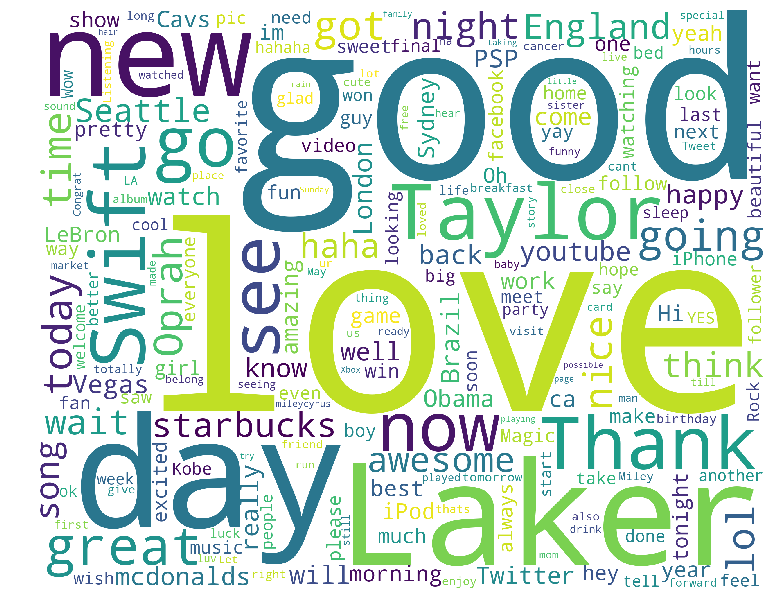

Negative words


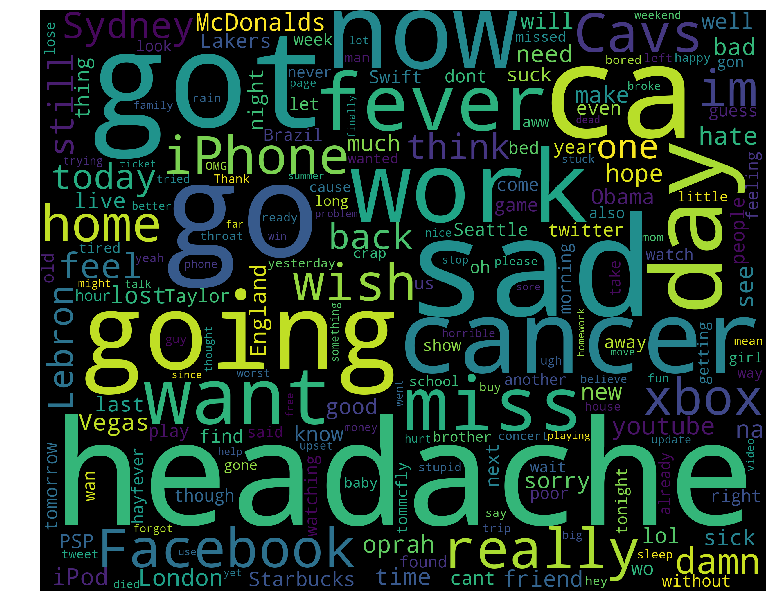

In [11]:
def wordcloud_draw(words, color='black'):
    wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color=color,
                      width=2500,
                      height=2000
                     ).generate(' '.join(words))
    plt.figure(1,figsize=(13, 13))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()

print("Positive words")
wordcloud_draw(pos_words,'white')
print("Negative words")
wordcloud_draw(neg_words)

### <div class="alert alert-block alert-success">Semantic Text Similarity</div>
Semantic Text Similarity is the process of analysing similarity between two pieces of text with respect to the meaning and essence of the text rather than analysing the syntax of the two pieces of text. Also, similarity is different than relatedness.

For example:
>*Car and Bus are similar **but** Car and Fuel are related.*

### <div class="alert alert-block alert-success">Topic Modeling</div>
Topic modeling is a frequently used text-mining tool for discovery of hidden semantic structures in a text body. Intuitively, given that a document is about a particular topic, one would expect particular words to appear in the document more or less frequently: "dog" and "bone" will appear more often in documents about dogs, "cat" and "meow" will appear in documents about cats, and "the" and "is" will appear equally in both. A document typically concerns multiple topics in different proportions; thus, in a document that is 10% about cats and 90% about dogs, there would probably be about 9 times more dog words than cat words. The "topics" produced by topic modeling techniques are clusters of similar words. A topic model captures this intuition in a mathematical framework, which allows examining a set of documents and discovering, based on the statistics of the words in each, what the topics might be and what each document's balance of topics is.

In [12]:
HTML(filename='img/LDA.html')

Animation of the topic detection process in a document-word matrix. Every column corresponds to a document, every row to a word. A cell stores the frequency of a word in a document, dark cells indicate high word frequencies. Topic models group both documents, which use similar words, as well as words which occur in a similar set of documents. The resulting patterns are called "topics" \[[5](http://topicmodels.west.uni-koblenz.de/ckling/tmt/svd_ap.html)\].

<video controls src="img/Topic_model_scheme.webm.360p.webm" />

# <div class="alert alert-block alert-info">Key text preprocessing techniques</div>
- Text Cleaning (RegExp)
- Tokenizing
- Stopwords removal
- Spelling Correction
- Synonyms Replacement
- Negation Replacement
- Stemming and Lemmatization
- N-grams adding

### <div class="alert alert-block alert-success">Text Cleaning (RegExp)</div>

- Replacement of contracted forms (e.g. I've, He's)
- Replacement of non-word characters
- Removing of punctuation
- Removing of tags, hyperlinks, etc.

[RegExp](https://www.cheatography.com/davechild/cheat-sheets/regular-expressions/pdf/)

### <div class="alert alert-block alert-success">Tokenizing</div>

The process of demarcating and possibly classifying sections of a string of input characters. The resulting tokens are then passed on to some other form of processing.

[More info](http://www.nltk.org/api/nltk.tokenize.html#module-nltk.tokenize)

### <div class="alert alert-block alert-success">Stopwords removal</div>
Stopwords &#8212; words that are discarded from a document representation.
- **Function words**: a, an, and, as, for, ...
- **Other frequent words**: 'Lotus' in a Lotus support

About 400 words in English

### <div class="alert alert-block alert-success">Spelling Correction</div>

[Enchant](http://pythonhosted.org/pyenchant/api/enchant.html) module provides several classes for performing spell checking via the Enchant spellchecking library.

### <div class="alert alert-block alert-success">Synonyms Replacement</div>
In purpose of reducing vocabulary size less frequient words are replaced with their more frequent synonyms.

> Flamboyant -> Bright

[More info](http://www.nltk.org/howto/wordnet.html)

### <div class="alert alert-block alert-success">Negation Replacement</div>
The opposite of synonym replacement is **antonym replacement**. An antonym is a word that has the opposite meaning of another word. Instead of creating custom word mappings, we can use WordNet to replace words with unambiguous antonyms. 

>Not bad -> Good

### <div class="alert alert-block alert-success">Stemming and Lemmatization</div>
Stemming and Lemmatization are the basic text processing methods. The goal of both stemming and lemmatization is to reduce inflectional forms and sometimes derivationally related forms of a word to a common base form.

**Stemming** &#8212; the process for reducing inflected (or sometimes derived) words to their stem, base or root form—generally a written word form. The stem need not be identical to the morphological root of the word; it is usually sufficient that related words map to the same stem, even if this stem is not in itself a valid root.

> 'flies' -> 'fli'

> 'denied' -> 'deni'

**Lemmatization** &#8212; the process of grouping together the different inflected forms of a word so they can be analysed as a single item. In many languages, words appear in several inflected forms. For example, in English, the verb ‘to walk’ may appear as ‘walk’, ‘walked’, ‘walks’, ‘walking’. The base form, ‘walk’, that one might look up in a dictionary, is called the lemma for the word. The combination of the base form with the part of speech is often called the lexeme of the word. 

**Lemmatization** is closely related to **stemming**. The difference is that a stemmer operates on a single word without knowledge of the context, and therefore cannot discriminate between words which have different meanings depending on part of speech. However, stemmers are typically easier to implement and run faster, and the reduced accuracy may not matter for some applications.

In [13]:
lemmatizer = Lemmatizer(LEMMA_INDEX, LEMMA_EXC, LEMMA_RULES)
lemmatizer('ducks', 'NOUN')

['duck']

### <div class="alert alert-block alert-success">N-grams adding</div>
**N-gram** - a contiguous sequence of n items from a given sample of text or speech. The items can be phonemes, syllables, letters, words or base pairs according to the application. The n-grams typically are collected from a text or speech corpus. 

An n-gram of size 1 is referred to as a `unigram`; size 2 is a `bigram` (or, less commonly, a `digram`); size 3 is a `trigram`.

<img src="img/ngrams.png" alt="N-grams" title="N-grams" />

> **'washing machine' &#8800; 'washing', 'machine'**

# <div class="alert alert-block alert-info">Key text vectorization techniques</div>
- BOW
- CountVec
- TF-IDF
- Hashing trick
- word2vec
- sent2vec
- doc2vec
- ...2vec

### <div class="alert alert-block alert-success">BOW</div>
We call **vectorization** the general process of turning a collection of text documents into numerical feature vectors. This specific strategy (tokenization, counting and normalization) is called the **Bag of Words** or **“Bag of n-grams”** representation. Documents are described by word occurrences while completely ignoring the relative position information of the words in the document.
<img src="img/BOW.png" alt="BOW" title="BOW" />

### <div class="alert alert-block alert-success">CountVec</div>
**TDM**

**Stopwords**
<img src="img/count_tdm_stopwords.png" alt="Count Vectorizer, TDM, Stopwords" title="Count Vectorizer, TDM, Stopwords" />

**DTM**
<img src="img/dtm.jpeg" alt="DTM" title="DTM" />

### <div class="alert alert-block alert-success">TF-IDF</div>

Term frequency-inverse document frequency (TF-IDF) is a feature vectorization method widely used in text mining to reflect the importance of a term to a document in the corpus. 

Denote a term by $t$, a document by $d$, and the corpus by $D$. 

**Term frequency $TF_{t,d}$** is the number of times that term $t$ appears in document $d$.

**Document frequency $DF_{t,D}$** is the number of documents in corpus that contains term $t$. 

If we only use term frequency to measure the importance, it is very easy to over-emphasize terms that appear very often but carry little information about the document, e.g., *“a”*, *“the”*, and *“of”*. If a term appears very often across the corpus, it means it doesn’t carry special information about a particular document. 

**Inverse document frequency $IDF_{t,D}$** is a numerical measure of how much information a term provides:
$$IDF_{t,D}=log\frac{|D|+1}{DF_{t,D}+1}$$
where $|D|$ is the total number of documents in the corpus. 

Since logarithm is used, if a term appears in all documents, its $IDF$ value becomes $0$. Note that a smoothing term ($1$) is applied to avoid dividing by zero for terms outside the corpus. 

The TF-IDF measure is simply the product of TF and IDF:
$$TF{\text-}IDF_{t,d,D}=TF_{t,d}\cdot IDF_{t,D}$$
<br>
<img height="50%" width="50%" src="img/tfidf.png" alt="TF-IDF" title="TF-IDF" />

### <div class="alert alert-block alert-success">Hashing trick</div>

Fast and space-efficient way of vectorizing features, i.e. turning arbitrary features into indices in a vector or matrix. It works by applying a hash function to the features and using their hash values as indices directly, rather than looking the indices up in an associative array.

This strategy has several advantages:

* it is very low memory scalable to large datasets as there is no need to store a vocabulary dictionary in memory
* it is fast to pickle and un-pickle as it holds no state besides the constructor parameters
* it can be used in a streaming (partial fit) or parallel pipeline as there is no state computed during fit.

There are also a couple of cons (vs using a CountVectorizer with an in-memory vocabulary):

* there is no way to compute the inverse transform (from feature indices to string feature names) which can be a problem when trying to introspect which features are most important to a model.
* there can be collisions: distinct tokens can be mapped to the same feature index. However in practice this is rarely an issue if n_features is large enough (e.g. 2 ** 18 for text classification problems).
* no IDF weighting as this would render the transformer stateful.


In [14]:
corpus = [
    'aa aaa ab ba bab aa',
    'ab aab bb bba ba bba'
]

count_vec = CountVectorizer().fit(corpus)
vocab_index = list(sorted(count_vec.vocabulary_.items(), key=lambda x: x[1]))
print('Vocabulary:\n', vocab_index, end='\n\n')

rows = []
for text, vect in zip(corpus, count_vec.transform(corpus).todense()):
    rows.append([text] + vect.tolist()[0])
    
vocab = [v for v, _ in vocab_index]
print('CountVec representation:')
print(tabulate(rows, ['text'] + vocab, tablefmt='grid'))

Vocabulary:
 [('aa', 0), ('aaa', 1), ('aab', 2), ('ab', 3), ('ba', 4), ('bab', 5), ('bb', 6), ('bba', 7)]

CountVec representation:
+----------------------+------+-------+-------+------+------+-------+------+-------+
| text                 |   aa |   aaa |   aab |   ab |   ba |   bab |   bb |   bba |
+======================+======+=======+=======+======+======+=======+======+=======+
| aa aaa ab ba bab aa  |    2 |     1 |     0 |    1 |    1 |     1 |    0 |     0 |
+----------------------+------+-------+-------+------+------+-------+------+-------+
| ab aab bb bba ba bba |    0 |     0 |     1 |    1 |    1 |     0 |    1 |     2 |
+----------------------+------+-------+-------+------+------+-------+------+-------+


In [15]:
def hash_func(s): return s[:2]

new_vocab = {hash_func(t) for t in count_vec.vocabulary_.keys()}
new_vocab_index = [(t, i) for i, t in enumerate(sorted(new_vocab))]

print('Hashed Vocabulary:\n', new_vocab_index, end='\n\n')

rows = []
for text in corpus:
    tokens = text.split()
    tokens_hashes = [hash_func(t) for t in tokens]
    counts = Counter(tokens_hashes)
    rows.append([text] + [counts[t] for t in sorted(new_vocab)])
    
print('Hishing trick. CountVec representation:')
print(tabulate(rows, ['text'] + list(sorted(new_vocab)), tablefmt='grid'))

Hashed Vocabulary:
 [('aa', 0), ('ab', 1), ('ba', 2), ('bb', 3)]

Hishing trick. CountVec representation:
+----------------------+------+------+------+------+
| text                 |   aa |   ab |   ba |   bb |
+======================+======+======+======+======+
| aa aaa ab ba bab aa  |    3 |    1 |    2 |    0 |
+----------------------+------+------+------+------+
| ab aab bb bba ba bba |    1 |    1 |    1 |    3 |
+----------------------+------+------+------+------+


### <div class="alert alert-block alert-success">word2vec</div>
<img src="img/w2v-1.png" alt="TF-IDF" title="TF-IDF" />
<img height="80%" width="80%" src="img/w2v-2.png" alt="TF-IDF" title="TF-IDF" />
[More info](http://mccormickml.com/2016/04/19/word2vec-tutorial-the-skip-gram-model/)